In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from keras import layers, models  # Updated 'models' for consistency
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
# from efficientnet import EfficientNetB0  # Assuming you install efficientnet
from keras import Model
from keras.layers.experimental import preprocessing
from keras.models import Sequential

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

2024-07-01 06:22:11.351110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 06:22:11.351147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 06:22:11.351966: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-01 06:22:11.357280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [3]:
dataset = "../../Smartbin/Dataset/Crawl_dataset/Data_real"
walk_through_dir(dataset)

There are 3 directories and 0 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real'.
There are 0 directories and 4061 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/UnRecycle'.
There are 0 directories and 8402 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Organic'.
There are 0 directories and 7552 images in '../../Smartbin/Dataset/Crawl_dataset/Data_real/Recycle'.


In [4]:
data_dir = Path(dataset)

filepaths = list(data_dir.glob(r'**/*.JPG')) + list(data_dir.glob(r'**/*.jpg')) + list(data_dir.glob(r'**/*.png')) + list(data_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df

,Filepath,Label
0,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
1,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
2,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
3,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
4,../../Smartbin/Dataset/Crawl_dataset/Data_real...,UnRecycle
...,...,...
21150,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21151,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21152,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle
21153,../../Smartbin/Dataset/Crawl_dataset/Data_real...,Recycle


In [6]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [7]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)

In [8]:
batch_size = 32
img_size = (200, 200)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 13540 validated image filenames belonging to 3 classes.
Found 3384 validated image filenames belonging to 3 classes.
Found 4231 validated image filenames belonging to 3 classes.


In [9]:
resize_and_rescale = tf.keras.Sequential([
    # layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1. / 255),
])

2024-07-01 06:22:13.826044: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 06:22:13.826317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-01 06:22:13.888125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [10]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_tensor=None,
    classes=3,
    classifier_activation='softmax',
    include_preprocessing=True
)
base_model.trainable = False 

In [11]:
inputs = base_model.inputs
x = resize_and_rescale(inputs)
x = Dense(256, activation='relu')(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)  

# Create the final model
model = Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [13]:
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 50,
                               restore_best_weights = True)

In [14]:
import time

class TimeHistory(Callback):
  def on_train_begin(self, logs=None):
    self.times = []
    self.epoch_start_time = time.time()  
  def on_epoch_end(self, epoch, logs=None):
    self.times.append(time.time() - self.epoch_start_time)
    self.epoch_start_time = time.time()
      
time_callback = TimeHistory()

In [15]:
history = model.fit(
  train_images,
  steps_per_epoch=len(train_images),
  validation_data=val_images,
  validation_steps=len(val_images),
  epochs=200,
  callbacks=[
    early_stopping,
    create_tensorboard_callback("training_logs", "bag_classification"),
    checkpoint_callback,
    time_callback
  ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20240701-062228


/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/200


2024-07-01 06:22:47.362839: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-01 06:22:53.419960: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 292.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 06:22:53.640809: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 733.62MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 06:22:55.050700: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 292.06MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there co

424/424 [==============================] - ETA: 0s - loss: 0.3085 - accuracy: 0.9060

2024-07-01 06:29:39.632141: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 686.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-01 06:29:41.292464: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 686.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


424/424 [==============================] - 446s 983ms/step - loss: 0.3085 - accuracy: 0.9060 - val_loss: 0.1094 - val_accuracy: 0.9660
Epoch 2/200
424/424 [==============================] - 390s 920ms/step - loss: 0.1149 - accuracy: 0.9634 - val_loss: 0.0914 - val_accuracy: 0.9719
Epoch 3/200
424/424 [==============================] - 389s 918ms/step - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.0802 - val_accuracy: 0.9746
Epoch 4/200
424/424 [==============================] - 385s 908ms/step - loss: 0.0734 - accuracy: 0.9752 - val_loss: 0.0771 - val_accuracy: 0.9743
Epoch 5/200
424/424 [==============================] - 320s 755ms/step - loss: 0.0652 - accuracy: 0.9790 - val_loss: 0.0709 - val_accuracy: 0.9772
Epoch 6/200
424/424 [==============================] - 277s 654ms/step - loss: 0.0520 - accuracy: 0.9816 - val_loss: 0.0699 - val_accuracy: 0.9770
Epoch 7/200
424/424 [==============================] - 280s 661ms/step - loss: 0.0478 - accuracy: 0.9842 - val_loss: 0.0690 - val_

In [16]:
total_training_time = sum(time_callback.times)
print("Total training time:", total_training_time, "seconds")

Total training time: 11213.749236106873 seconds


In [1]:
results = model.evaluate(test_images)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

NameError: name 'model' is not defined

133/133 [==============================] - 36s 245ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


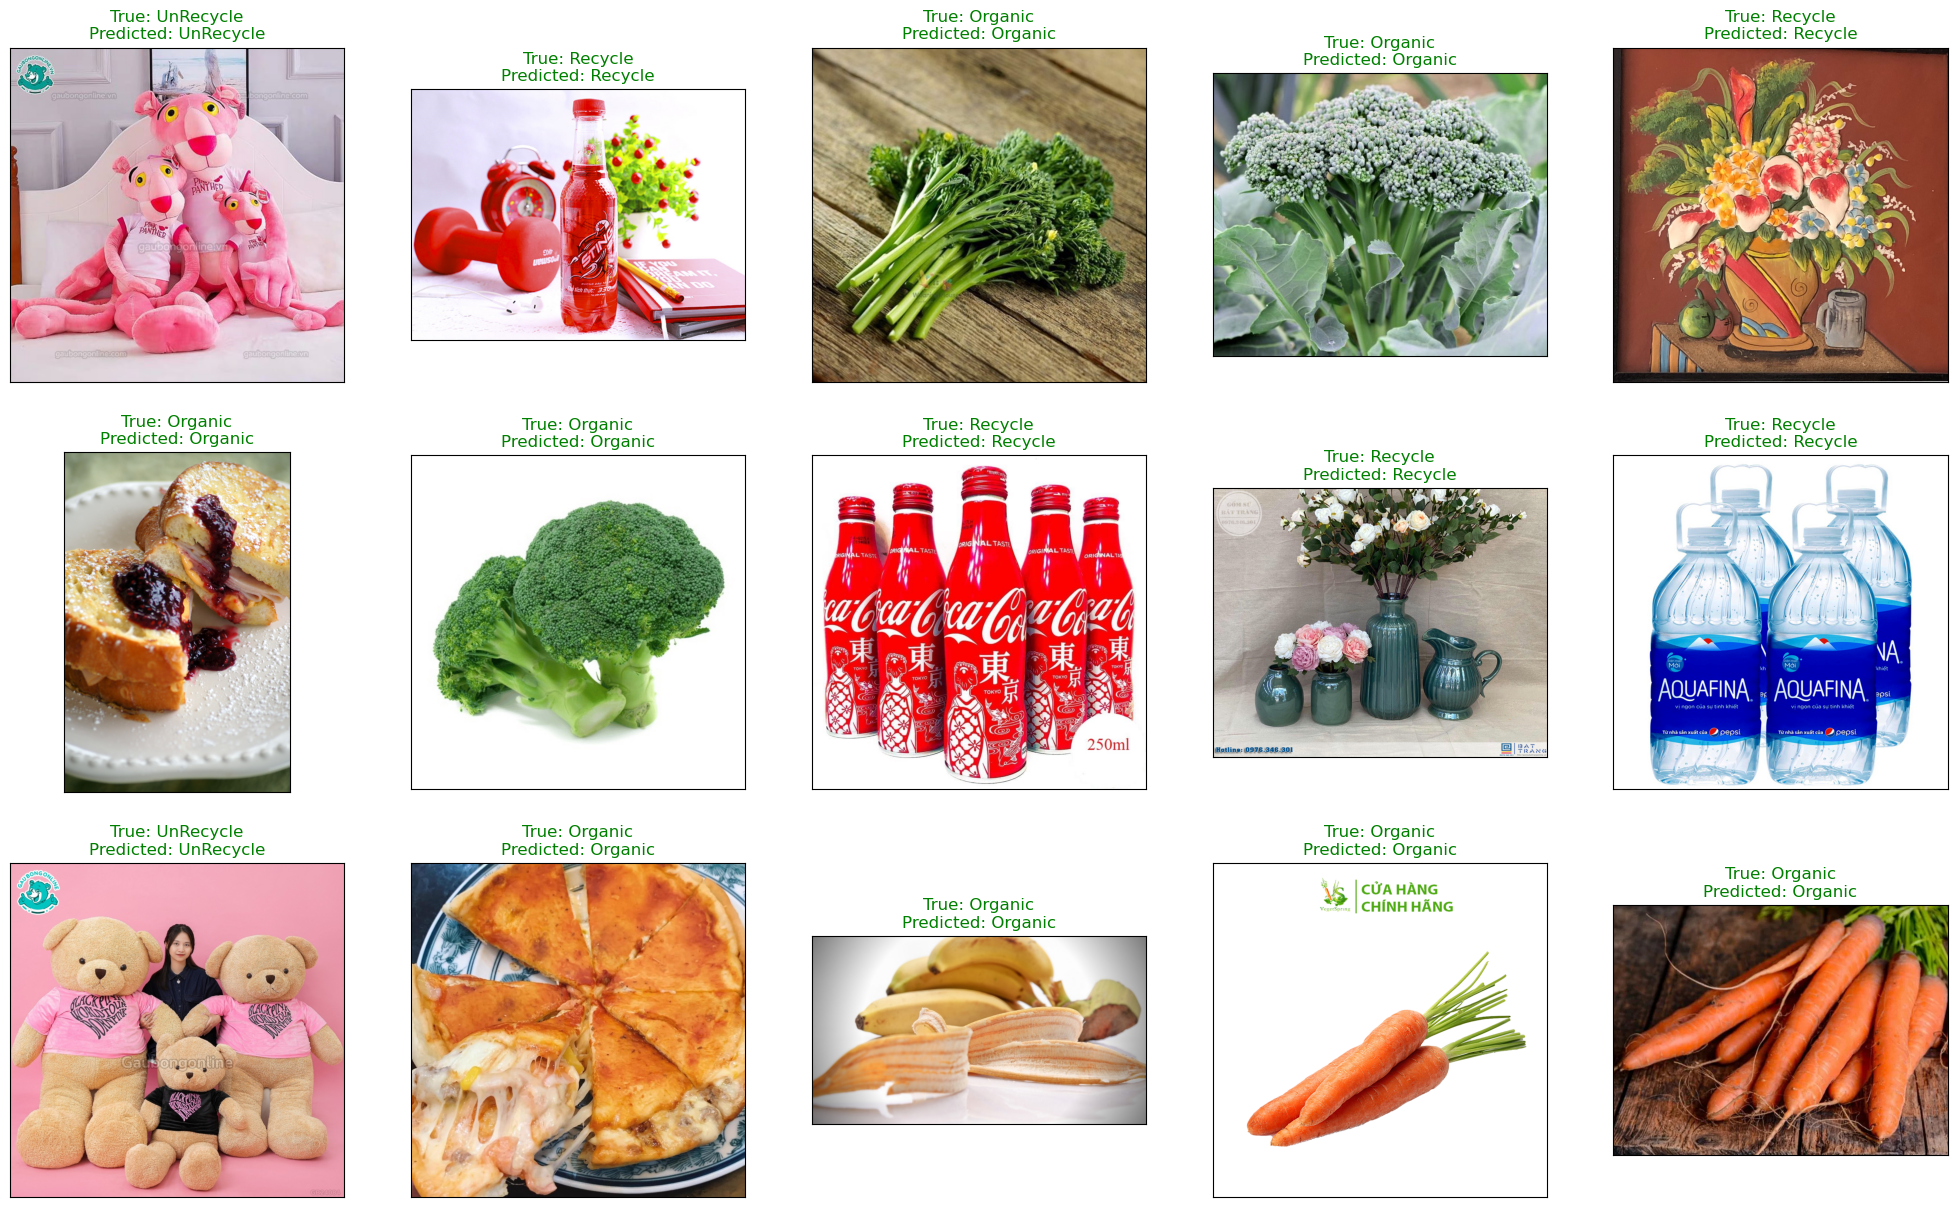

<Figure size 640x480 with 0 Axes>

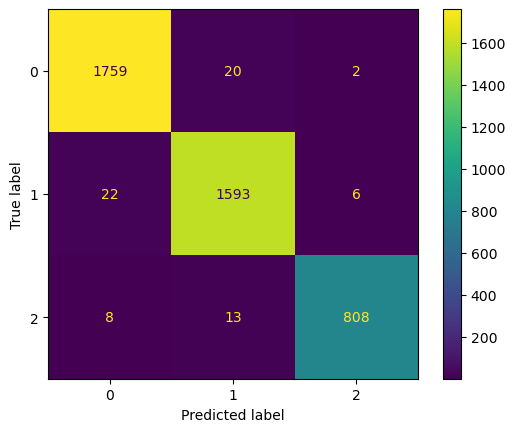

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
history.history

# In ra dự đoán và so sánh với nhãn thực tế
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 10 predictions: {pred[:10]}')

# Hiển thị một số ví dụ dự đoán
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [19]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

  5/133 [>.............................] - ETA: 33s

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


133/133 [==============================] - 33s 246ms/step
The first 10 predictions: ['UnRecycle', 'Recycle', 'Organic', 'Recycle', 'Recycle', 'Organic', 'Recycle', 'UnRecycle', 'Organic', 'Recycle']


In [20]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Organic,0.983231,0.987647,0.985434,1781.000000
Recycle,0.979705,0.982727,0.981213,1621.000000
UnRecycle,0.990196,0.974668,0.982371,829.000000
accuracy,0.983219,0.983219,0.983219,0.983219
macro avg,0.984377,0.981681,0.983006,4231.000000
weighted avg,0.983245,0.983219,0.983217,4231.000000


In [21]:
model.save('effnet_l2_model.h5')

/home/jupyter-iec_smartbin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
